In [1]:
from __future__ import division
import sys
sys.path.insert(0, '/home/gw2397/cluster_new')
sys.path.insert(0, '/home/gw2397/pyhsmm-autoregressive-master')
sys.path.insert(0, '/home/gw2397/nbRegg_mcmc')

import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import *
from scipy.interpolate import *
from cluster_functions import *


import pyhsmm
from pyhsmm.util.text import progprint_xrange
from pyhsmm.util.stats import whiten, cov

import autoregressive.models as m
import autoregressive.distributions as d

from polyagamma import random_polyagamma
from pyhmc import hmc
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.special import gamma, digamma
from scipy.stats import norm, nbinom, multivariate_normal
from tqdm import tqdm
import heapq

import numpy.matlib
import time
from IPython import display

import warnings
warnings.filterwarnings("ignore")
import copy

import numpy as np
from matplotlib import pyplot as plt
# import shelve
import pickle

from pymc3_hpd import *
from scipy import stats
from scipy.linalg import lstsq

from matplotlib.ticker import MaxNLocator

/home/gw2397/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/gw2397/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/gw2397/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/gw2397/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
from __future__ import division
import sys
sys.path.insert(0, '/home/gw2397/cluster_new')
sys.path.insert(0, '/home/gw2397/pyhsmm-autoregressive-master')
sys.path.insert(0, '/home/gw2397/nbRegg_mcmc')


# load results

In [3]:
path = "/scratch/gw2397/sim_NB/"
# path = "/scratch/gw2397/sim_NB/old_results/"
filename = "NB_sim"

In [4]:
with open(path + filename + '_t_fit.pkl', 'rb') as f: t_fit_NB = pickle.load(f)
with open(path + filename + '_states_fit.pkl', 'rb') as f: states_fit_NB = pickle.load(f)
with open(path + filename + '_Z_fit.pkl', 'rb') as f: Z_fit_NB = pickle.load(f)


In [5]:
n_iter = t_fit_NB.shape[0]
iter_use_start = int(n_iter/4)

# 1. Histograms of # of clusters

In [6]:
def intHist(data):
    d = np.diff(np.unique(data)).min()
    left_of_first_bin = data.min() - float(d)/2
    right_of_last_bin = data.max() + float(d)/2
    plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))

## 1A. nCluster of neuron

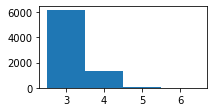

In [7]:
plt.rcParams['figure.figsize'] = [3, 1.5]
intHist(t_fit_NB[iter_use_start:])
plt.savefig("hist_nNeuron.svg")

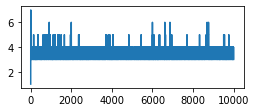

In [8]:
plt.rcParams['figure.figsize'] = [4, 1.5]
plt.plot(t_fit_NB)
plt.savefig("trace_nNeuron.svg")

# 1B. nCluster of states

In [9]:
def nStates(states_fit):
    n_iter = states_fit.shape[0]
    n_states_fit = np.zeros((n_iter,), dtype = int)
    for kk in range(n_iter):
        n_states_fit[kk] = np.unique(states_fit[kk,:]).size
    return n_states_fit

In [10]:
n_states_fit_NB = nStates(states_fit_NB)

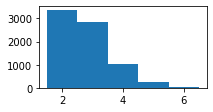

In [11]:
plt.rcParams['figure.figsize'] = [3, 1.5]
intHist(n_states_fit_NB[iter_use_start:])
plt.savefig("hist_nStates.svg")

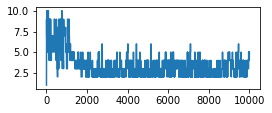

In [12]:
plt.rcParams['figure.figsize'] = [4, 1.5]
plt.plot(n_states_fit_NB)
plt.savefig("trace_nState.svg")

# 2. Similarity matrix

In [13]:
n = 10
nClus = 3
p = 2
T = 500

np.random.seed(0)
lab_neuron = np.repeat(np.arange(nClus), n)

dd = np.random.normal(size = (n*nClus,1))*0.5
C_true= np.random.normal(size = (nClus*n,p))*0.5

# works well
As = [block_diag(0.01*np.eye(p+1), 
                 0.01*np.eye(p+1), 
                 0.01*np.eye(p+1)),
      block_diag(1.01*random_rotation(p+1, theta= np.pi/20),
                 1.01*random_rotation(p+1, theta= np.pi/20),
                 1.01*random_rotation(p+1, theta= np.pi/20))]


truemodel = m.ARHSMM(
        alpha=5.,init_state_concentration=5.,
        obs_distns=[d.AutoRegression(A=A,sigma=np.eye(nClus*(p+1))*1e-2) for A in As],
        dur_distns=[pyhsmm.basic.distributions.PoissonDuration(alpha_0=100,beta_0=2)
            for state in range(len(As))],
        )


X_all_tmp, lab_t_tmp = truemodel.generate(2*T, keep=True)
X_all = X_all_tmp[501:,:].T
lab_t = lab_t_tmp[500:]


muX_all = []
for cc in range(nClus):
    muX_all.append(X_all[(cc*(p+1)):((cc+1)*(p+1)),:])
    
dynm = {}
dynm['As'] = np.zeros((2,3*(p+1),3*(p+1)))
dynm['bs'] = np.zeros((2,3*(p+1)))
dynm['Qs'] = np.zeros((2,3*(p+1),3*(p+1)))
dynm['states'] = np.zeros((T,), dtype = int)


# muX_b, C_b, delt_b.ravel(), dynamics_b

muX_all, C_true, _, _ = constraint(muX_all, C_true,dd.reshape((-1, 1)),dynm, lab_neuron)    
X_all = np.zeros_like(X_all)
for cc in range(nClus):
    X_all[(cc*(p+1)):((cc+1)*(p+1)),:] = muX_all[cc]

    
C_trans = np.zeros((n*nClus, (p+1)*nClus))
for cc in range(nClus):
    C_trans[(n*cc):(n*(cc+1)),(cc*(p+1)):((cc+1)*(p+1))] = np.column_stack((np.ones((n,1)), C_true[(n*cc):(n*(cc+1)),:]))    
    
Lam_true = np.exp(dd + C_trans @ X_all)
r_true = np.ones((n*nClus,1))*10
p_true = r_true/(r_true+Lam_true)
y = np.random.negative_binomial(r_true, p_true, size=None)

## 2A. neuron

In [14]:
N = Z_fit_NB.shape[1]
simMat_neuron = np.zeros((N,N))
count = 0
for g in range(iter_use_start, n_iter):
    count = count + 1
    for k in range(simMat_neuron.shape[0]):
        simMat_neuron[k,:] = simMat_neuron[k,:] + (Z_fit_NB[g,k] == Z_fit_NB[g,:])
simMat_neuron = simMat_neuron/count

simMat_neuron_true = np.zeros((N,N))
for k in range(simMat_neuron_true.shape[0]):
    simMat_neuron_true[k,:] = (lab_neuron[k] == lab_neuron)

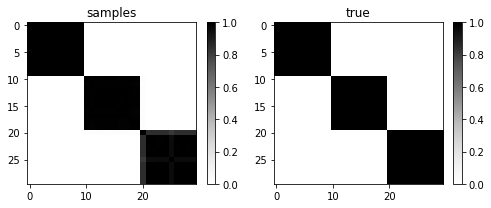

In [15]:
plt.rcParams['figure.figsize'] = [7, 3]
fig, ax = plt.subplots(1, 2)
z1 = ax[0].imshow(simMat_neuron, aspect="auto", cmap = 'Greys')
ax[0].set_title('samples')
plt.colorbar(z1, ax= ax[0])
z2 = ax[1].imshow(simMat_neuron_true, aspect="auto", cmap = 'Greys')
ax[1].set_title('true')
plt.colorbar(z2, ax= ax[1])
fig.tight_layout()

plt.rcParams['figure.figsize'] = [5, 5]
plt.savefig("simMat_neuron.svg")

## 2B. states

In [16]:
simMat_state = np.zeros((T,T))
count = 0

for g in range(iter_use_start, n_iter):
    count = count + 1
    for k in range(simMat_state.shape[0]):
        simMat_state[k,:] = simMat_state[k,:] + (states_fit_NB[g,k] == states_fit_NB[g,:])
simMat_state = simMat_state/count

simMat_state_true = np.zeros((T,T))
for k in range(simMat_state_true.shape[0]):
    simMat_state_true[k,:] = (lab_t[k] == lab_t)
sim_order = np.append(np.where(lab_t == 0)[0], np.where(lab_t == 1)[0])

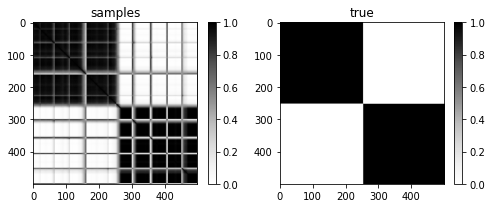

In [17]:
plt.rcParams['figure.figsize'] = [7, 3]
fig, ax = plt.subplots(1, 2)
z1 = ax[0].imshow(simMat_state[np.ix_(sim_order, sim_order)], aspect="auto", cmap = 'Greys')
ax[0].set_title('samples')
plt.colorbar(z1, ax= ax[0])
z2 = ax[1].imshow(simMat_state_true[np.ix_(sim_order, sim_order)], aspect="auto", cmap = 'Greys')
ax[1].set_title('true')
plt.colorbar(z2, ax= ax[1])
fig.tight_layout()

plt.rcParams['figure.figsize'] = [5, 5]
plt.savefig("simMat_states.svg")

# 3. maxPEAR of states
Here, I need to use the R package...
First, output the samples for state to csv

In [18]:
states_samp_use = states_fit_NB[iter_use_start:,:]
np.savetxt("states_samp.csv", states_samp_use, delimiter=",")

In [19]:
states_samp_maxPEAR = np.loadtxt("states_samp_maxPEAR.csv", delimiter=",", dtype = int) - 1

# align to truth
np.unique(states_samp_maxPEAR) # 2
swap = {0: 1, 1:0}
states_samp_maxPEAR_swap = np.array([swap[x] for x in states_samp_maxPEAR])

sum((states_samp_maxPEAR - lab_t)**2)
sum((states_samp_maxPEAR_swap - lab_t)**2)

477

## 3A. maxPEAR of the states

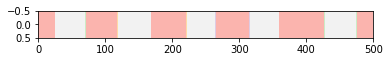

In [20]:
plt.rcParams['figure.figsize'] = [6, .5]
plt.imshow(states_samp_maxPEAR[None,:], aspect="auto", cmap='Pastel1')
plt.xlim([0, T])
plt.savefig("states_maxPEAR.svg")

## 3B. true states

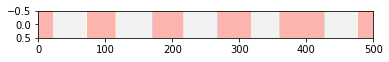

In [21]:
plt.imshow(lab_t[None,:], aspect="auto", cmap='Pastel1')
plt.xlim([0, T])
plt.savefig("states_true.svg")

# 4. latent trajectories

In [22]:
with open(path + filename + '_muX_fit.pkl', 'rb') as f: muX_fit_NB = pickle.load(f)

In [23]:
unique_lab = np.sort(np.unique(lab_neuron))
neuron_set = {}
for zz in unique_lab:
    neuron_set[zz] = np.where(lab_neuron == zz)[0]

In [24]:
z_clus_plot = np.ones((unique_lab.size, n_iter), dtype = int)*-99
mu_clus_plot = np.zeros((n_iter,unique_lab.size,T))
X_clus_plot = []
for _ in unique_lab:
    X_clus_plot.append(np.zeros((n_iter, p, T)))

In [25]:
for idx, zz in enumerate(unique_lab):
    obsIdx = (lab_neuron==zz)
    z_clus_plot[idx,:] = stats.mode(Z_fit_NB[:,obsIdx].T)[0][0]
    
    for kk in range(n_iter):
        mu_clus_plot[kk,idx,:] = muX_fit_NB[kk][z_clus_plot[idx,kk]][0,:]
        X_clus_plot[idx][kk,:,:] = muX_fit_NB[kk][z_clus_plot[idx,kk]][1:,:]

In [26]:
muMean_plot = np.zeros((unique_lab.size, T))
muLB_plot = np.zeros((unique_lab.size, T))
muUB_plot = np.zeros((unique_lab.size, T))

for ii in range(unique_lab.size):
    mu_samp = mu_clus_plot[iter_use_start:,ii,:]
    hdp_tmp = hpd(mu_samp, alpha=0.025)
    
    muMean_plot[ii,:] = np.mean(mu_samp,0)
    muLB_plot[ii,:] = hdp_tmp[:,0]
    muUB_plot[ii,:] = hdp_tmp[:,1]


In [27]:
muMean_plot = np.zeros((unique_lab.size, T))
muLB_plot = np.zeros((unique_lab.size, T))
muUB_plot = np.zeros((unique_lab.size, T))

for ii in range(unique_lab.size):
    mu_samp = mu_clus_plot[iter_use_start:,ii,:].copy()
    hdp_tmp = hpd(mu_samp, alpha=0.025)
    
    muMean_plot[ii,:] = np.mean(mu_samp,0)
    muLB_plot[ii,:] = hdp_tmp[:,0]
    muUB_plot[ii,:] = hdp_tmp[:,1]

In [28]:
XMean_plot = []
XLB_plot = []
XUB_plot = []

# muX_all_rot = copy.deepcopy(muX_all)

for ii in range(unique_lab.size):
    
    X_samp_tmp = copy.deepcopy(X_clus_plot[ii][iter_use_start:,:,:])
    
    XMean_tmp = np.mean(X_samp_tmp, axis = 0)
    rot_tmp = lstsq(XMean_tmp.T,muX_all[ii][1:,].T)[0].T
    
    for kk in range(X_samp_tmp.shape[0]):
        X_samp_tmp[kk,:,:] = rot_tmp @ X_samp_tmp[kk,:,:]
    
    XMean_tmp = np.zeros((p,T))
    XLB_tmp = np.zeros((p,T))
    XUB_tmp = np.zeros((p,T))
    for jj in range(p):
        X_samp_sub = X_samp_tmp[:,jj,:]
        Xhdp_tmp = hpd(X_samp_sub, alpha=0.025)
        
        XMean_tmp[jj,:] = np.mean(X_samp_sub,0)
        XLB_tmp[jj,:] = Xhdp_tmp[:,0]
        XUB_tmp[jj,:] = Xhdp_tmp[:,1]
    
    
#     rot_tmp = lstsq(muX_all[ii][1:,].T,XMean_tmp.T)[0].T
#     muX_all_rot[ii][1:,] = rot_tmp @ muX_all_rot[ii][1:,]
    
    XMean_plot.append(XMean_tmp)
    XLB_plot.append(XLB_tmp)
    XUB_plot.append(XUB_tmp)

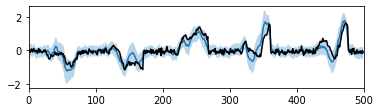

In [29]:
plt.rcParams['figure.figsize'] = [6, 1.5]

ii=0
plt.plot(muMean_plot[ii,:])
plt.fill_between(np.arange(0,T), muUB_plot[ii,:], muLB_plot[ii,:], alpha=0.3)
# plt.plot(muX_all_rot[ii][0,:], 'k')
plt.plot(muX_all[ii][0,:], 'k')
plt.xlim([0, T])
plt.savefig("mu.svg")

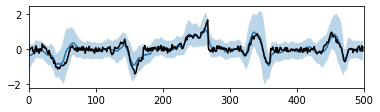

In [30]:
jj = 0

plt.plot(XMean_plot[ii][jj,:])
plt.fill_between(np.arange(0,T), XLB_plot[ii][jj,:], XUB_plot[ii][jj,:], alpha=0.3)
# plt.plot(muX_all_rot[ii][jj+1,], 'k')
plt.plot(muX_all[ii][jj+1,], 'k')
plt.xlim([0, T])
plt.savefig("x1.svg")

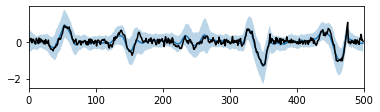

In [31]:
jj = 1

plt.plot(XMean_plot[ii][jj,:])
plt.fill_between(np.arange(0,T), XLB_plot[ii][jj,:], XUB_plot[ii][jj,:], alpha=0.3)
# plt.plot(muX_all_rot[ii][jj+1,], 'k')
plt.plot(muX_all[ii][jj+1,], 'k')
plt.xlim([0, T])
plt.savefig("x2.svg")

In [32]:
muNorm_trace = np.zeros([n_iter, unique_lab.size])
for ii in range(unique_lab.size):
    muNorm_trace[:,ii] = np.sqrt(np.sum(mu_clus_plot[:,ii,:]**2, axis=1))

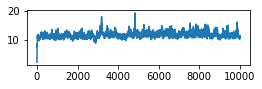

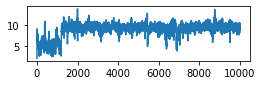

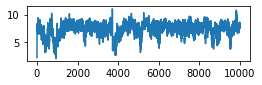

In [33]:
plt.rcParams['figure.figsize'] = [4, 1]


for ii in range(unique_lab.size):
    plt.figure()
    plt.plot(muNorm_trace[:,ii])
    plt.savefig("trace_mu" + str(ii) + ".svg")

In [40]:
X_raw = []
X_trans = []
for ii in range(unique_lab.size):
    X_samp_tmp = X_clus_plot[ii].copy()
    
    X_raw.append(X_clus_plot[ii])
    
    XMean_tmp = np.mean(X_samp_tmp, axis = 0)
    rot_tmp = lstsq(XMean_tmp.T,muX_all[ii][1:,].T)[0].T
    
    for kk in range(X_samp_tmp.shape[0]):
        X_samp_tmp[kk,:,:] = rot_tmp @ X_samp_tmp[kk,:,:]
    
    X_trans.append(X_samp_tmp)

In [41]:

XFrob_norm_raw = np.zeros([n_iter, unique_lab.size])
XFrob_norm = np.zeros([n_iter, unique_lab.size])

for ii in range(unique_lab.size):
    for jj in range(X_trans[ii].shape[0]):
        XFrob_norm_raw[jj,ii] = np.sqrt(np.sum(X_raw[ii][jj]**2)) 
        XFrob_norm[jj,ii] = np.sqrt(np.sum(X_trans[ii][jj]**2)) 

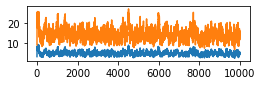

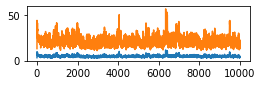

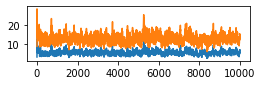

In [42]:
plt.rcParams['figure.figsize'] = [4, 1]

for ii in range(unique_lab.size):
    plt.figure()
    plt.plot(XFrob_norm_raw[:,ii])
    plt.plot(XFrob_norm[:,ii])
    plt.savefig("trace_xF" + str(ii) + ".svg")